# $\sigma$-clipping:
The notebooks prior where the errors were first introduced has the odd combination of assuming LIGO sees every event while also putting in a measurement error that roughly depends on how detectable the object is. In the next section, objects where $\frac{\sigma}{\mu}>\sigma_{cut}$ for _either_ $m_1$ or $d_L$ will be removed, as LIGO would likely ignore them anyways. Looking at the line plot of two error functions way above, this will likely remove quite a few of them

Because this relies on the emprical errors associated with measurements, the bootstrap method can't be applied here

In [17]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

In [18]:
ms = generate_masses(f=0.5)
dLs = generate_dLs(R=Planck18.luminosity_distance(1.5))
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)

In [19]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

In [20]:
sigma_cut = 0.1 ## roughly correponds to SNR of 5


n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
quant_min = 0.05 #quantile mins and maxs
quant_max = 0.95

In [43]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
cutoff_d = 22000
d_low_dl = dLs[dLs < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))
dL_cent = np.linspace(1800, 5500, n_dLs)

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

In [44]:
dL_cut = dLs[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
ms_cut = m_det[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_ms_cut = sigma_ms[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_dL_cut = sigma_dls[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]

100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Text(0.5, 1.0, '$\\sigma$-clipping at $\\frac{\\sigma_{max}}{\\mu}=0.1$')

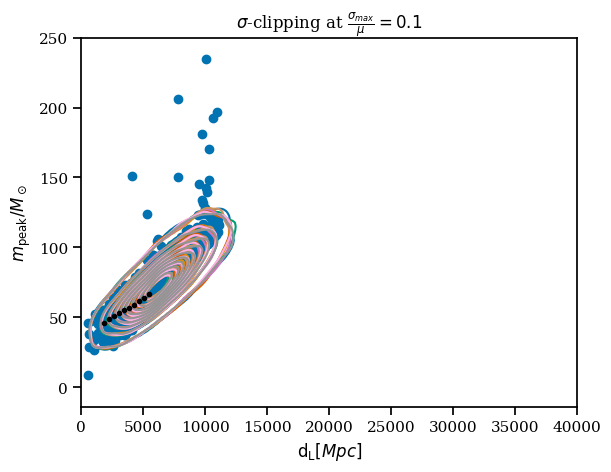

In [45]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(dL_cut, ms_cut)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0, 40000)
plt.ylim(top=250)
plt.title(r"$\sigma$-clipping at $\frac{\sigma_{max}}{\mu}=%.1f$" %(sigma_cut))

In [46]:
print(f"Looks like there's a very hard dL cutoff at {max(dL_cut)} Mpc")

Looks like there's a very hard dL cutoff at 11136.177402811909 Mpc


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


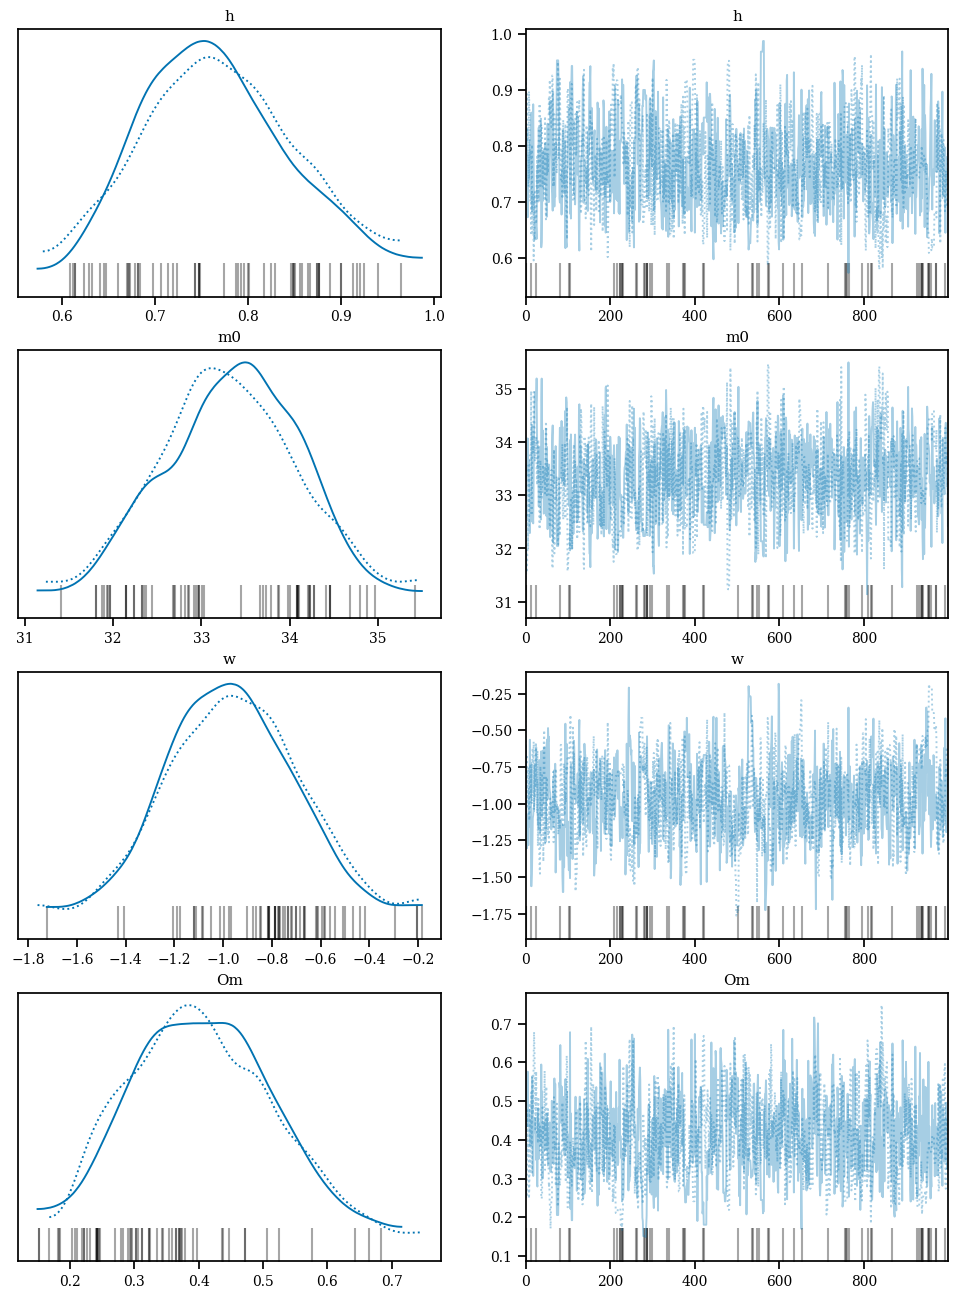

In [47]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=1.5) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

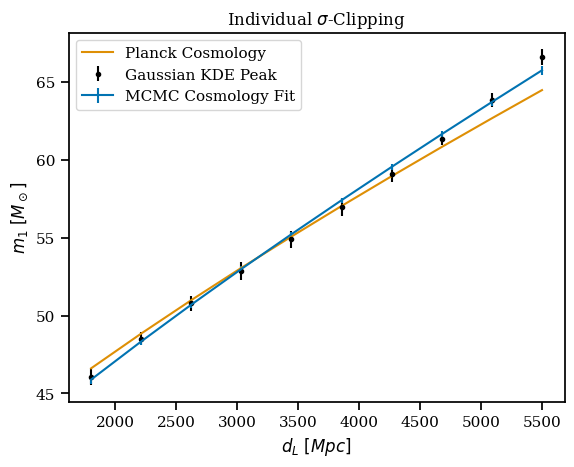

In [48]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.title(r"Individual $\sigma$-Clipping")
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.legend()

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

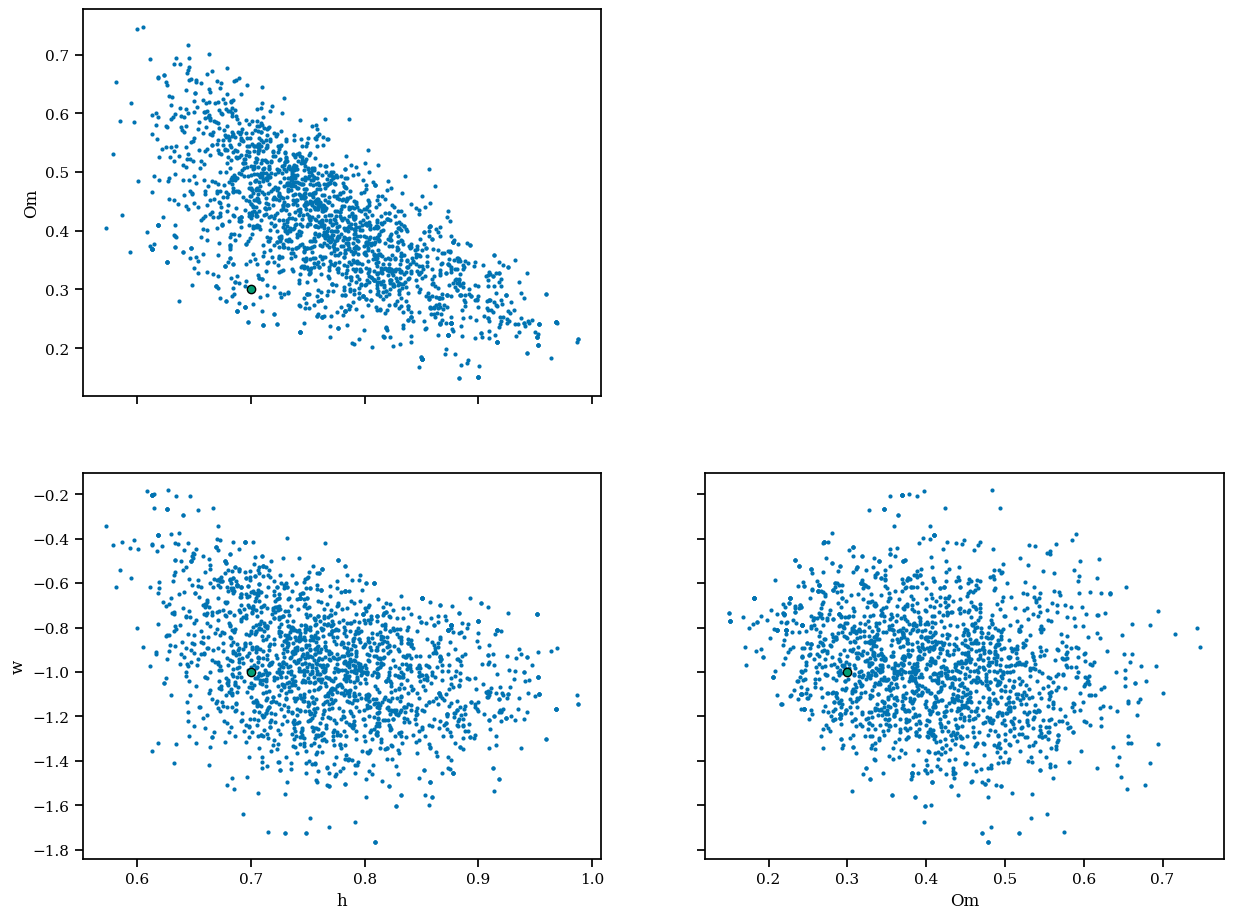

In [49]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

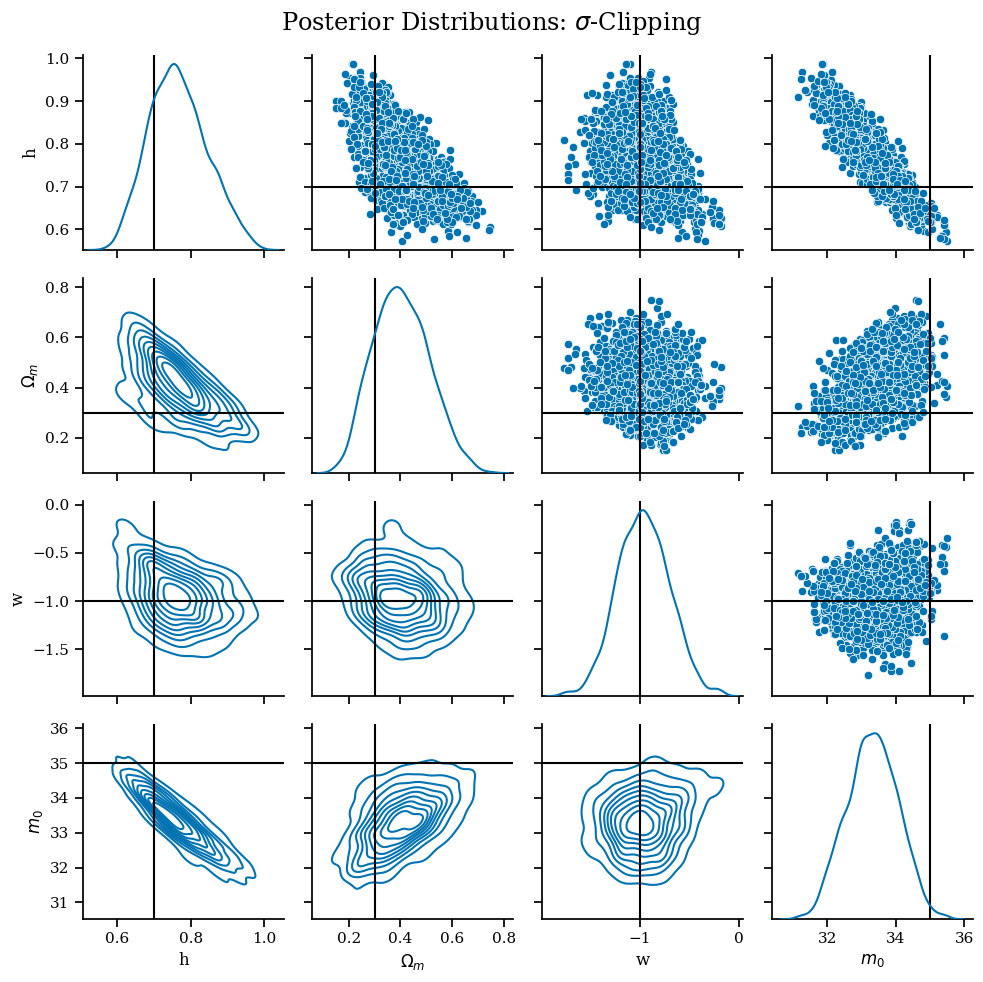

In [50]:
LIGO_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(LIGO_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')
g.figure.suptitle(r"Posterior Distributions: $\sigma$-Clipping", size='x-large')
g.figure.tight_layout()

## Joint $\sigma$ clipping

Now we're going to do a joint sigma clipping that is $SNR^2 = SNR_{dL}^2 + SNR_m^2$ and limit *that* to the cutoff of 5

In [51]:
quant_min = 0.05 #quantile mins and maxs
quant_max = 0.95

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(quant_min, quant_max, n_dLs))
dL_cent = np.linspace(2000, 8000, n_dLs)

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

In [52]:
snr_m = 1/sigma_ms
snr_dLs = 1/sigma_dls
snr_tot = np.sqrt(snr_m**2 + snr_dLs**2)
sigma_tot = 1/snr_tot

In [53]:
dL_cut = dLs[sigma_tot < sigma_cut]
ms_cut = m_det[sigma_tot < sigma_cut]
sigma_ms_cut = sigma_ms[sigma_tot < sigma_cut]
sigma_dL_cut = sigma_dls[sigma_tot < sigma_cut]

100%|██████████| 8/8 [01:05<00:00,  8.17s/it]


Text(0.5, 1.0, '$\\sigma$-clipping at $\\frac{\\sigma_{max}}{\\mu}=0.1$')

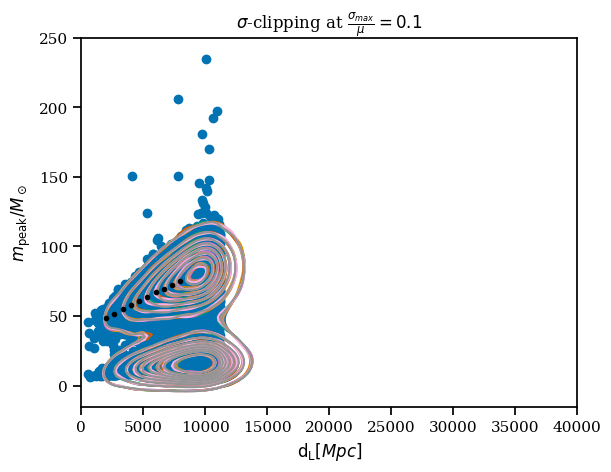

In [54]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(dL_cut, ms_cut)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0, 40000)
plt.ylim(top=250)
plt.title(r"$\sigma$-clipping at $\frac{\sigma_{max}}{\mu}=%.1f$" %(sigma_cut))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


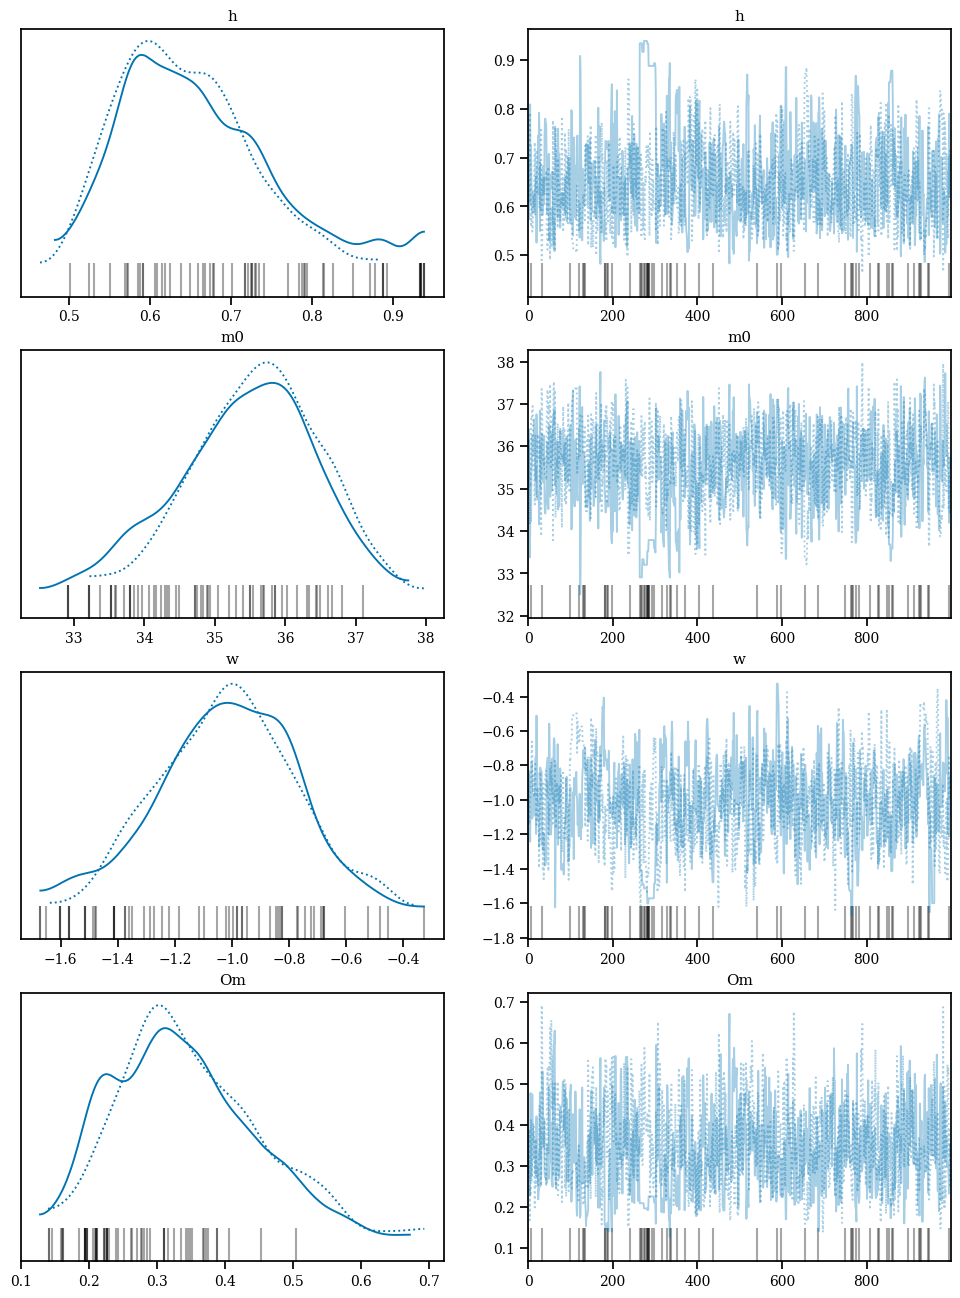

In [55]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

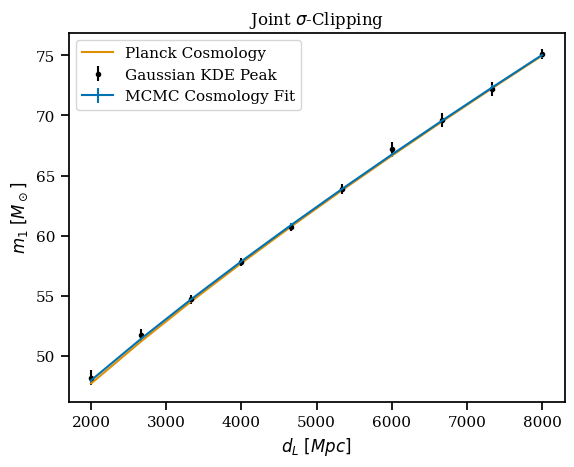

In [56]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.title(r"Joint $\sigma$-Clipping")
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.legend()

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

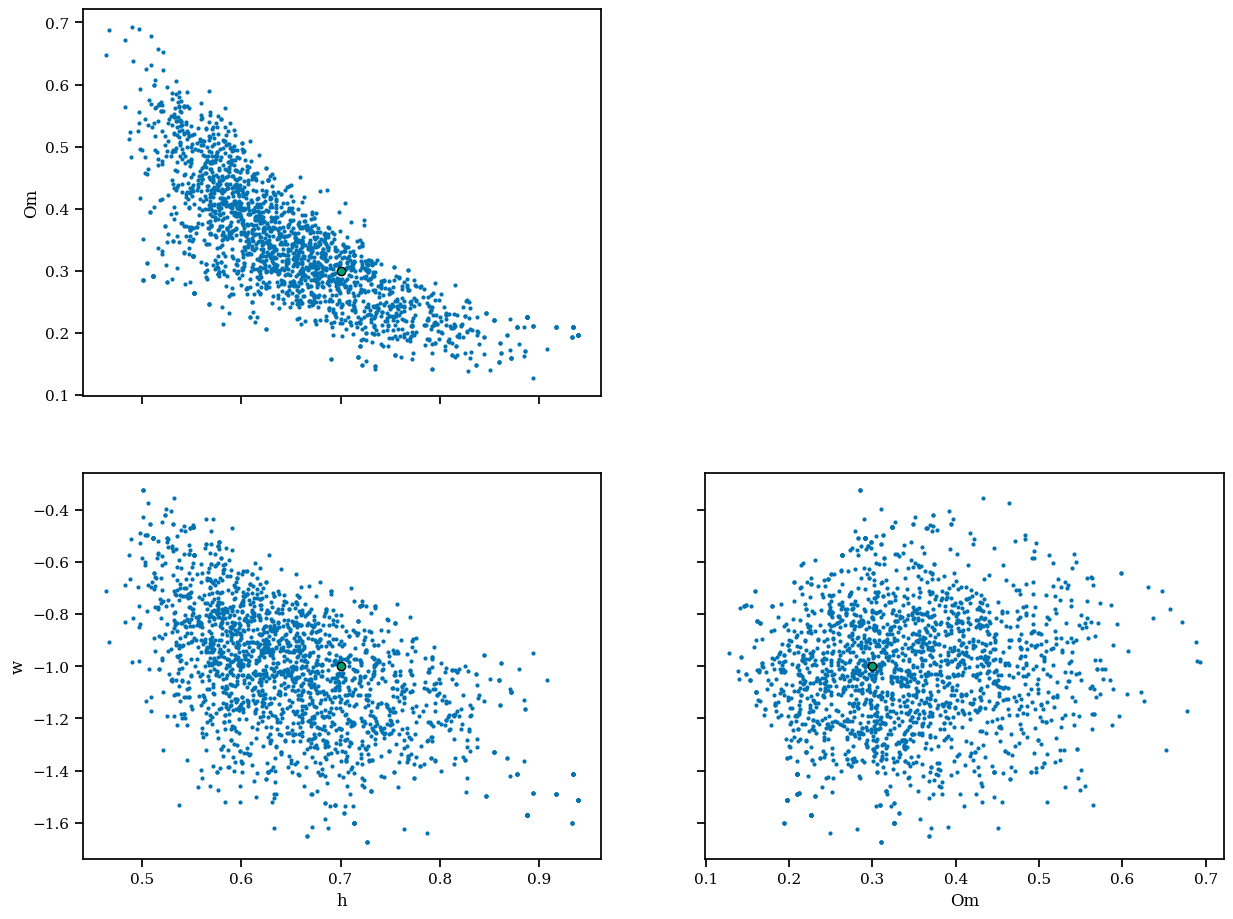

In [57]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

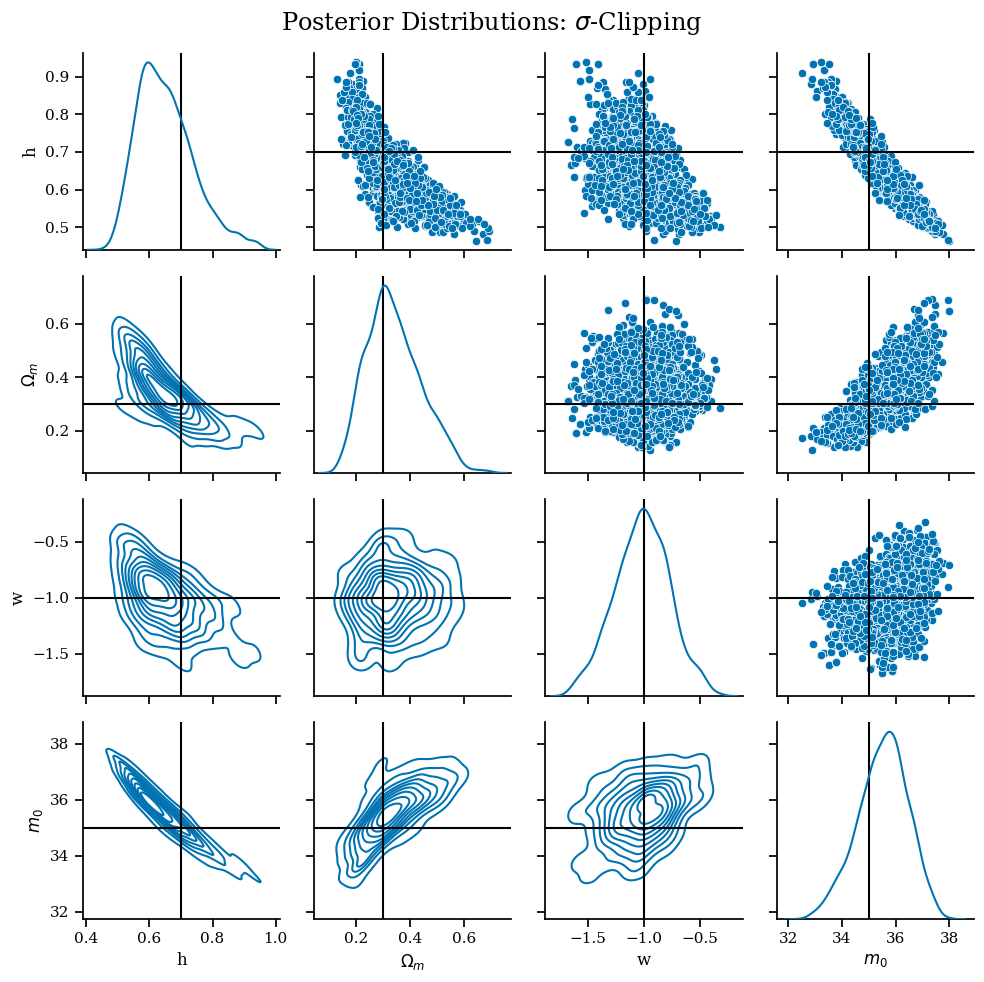

In [58]:
LIGO_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(LIGO_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')
g.figure.suptitle(r"Posterior Distributions: $\sigma$-Clipping", size='x-large')
g.figure.tight_layout()